In [41]:
import json
import string
import os
import shutil
import re
import pickle
import nltk
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
from tqdm import tqdm
from collections import OrderedDict
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [44]:
x_train_df = pd.read_csv("../dataset/data/x_train.csv")
y_train_df = pd.read_csv("../dataset/data/y_train.csv")
x_test_df = pd.read_csv("../dataset/data/x_test.csv")
y_test_df = pd.read_csv("../dataset/data/y_test.csv")

In [45]:
items = pd.read_csv('../dataset/dressipi_recsys2022/item_features.csv')
items = sorted(set(items['item_id'].tolist()))

In [6]:
items_map = {k:c for c, k in enumerate(items)}

In [46]:
embedding_matrix = np.load('../dataset/ICM.npy')

In [10]:
train_session_items_map = x_train_df.groupby('session_id')['item_id'].apply(list).to_dict()
test_session_items_map = x_test_df.groupby('session_id')['item_id'].apply(list).to_dict()

In [11]:
y_train_df.sort_values(by=['session_id'],inplace=True)
train_session_items_map = OrderedDict(sorted(train_session_items_map.items()))

In [12]:
y_test_df.sort_values(by=['session_id'],inplace=True)
test_session_items_map = OrderedDict(sorted(test_session_items_map.items()))

In [13]:
x_train = list(map(list, (train_session_items_map.values())))
y_train = y_train_df['item_id'].tolist()
x_test = list(map(list, (test_session_items_map.values())))
y_test = y_test_df['item_id'].tolist()

In [14]:
for i in tqdm(range(len(x_train))):
  for j in range(len(x_train[i])):
    x_train[i][j] = items_map[x_train[i][j]]

for i in tqdm(range(len(x_test))):
  for j in range(len(x_test[i])):
    x_test[i][j] = items_map[x_test[i][j]]  

for i in tqdm(range(len(y_train))):
  y_train[i] = items_map[y_train[i]]  

for i in tqdm(range(len(y_test))):
  y_test[i] = items_map[y_test[i]] 

100%|██████████| 81618/81618 [00:00<00:00, 1873177.63it/s]


In [15]:
train_max_len = len(max(x_train,key=len))
x_train_sequence = pad_sequences(x_train,maxlen=train_max_len)
x_test_sequence = pad_sequences(x_test,maxlen=train_max_len)

In [16]:
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [17]:
EMBEDDING_DIM = 64
num_items = embedding_matrix.shape[0]
size_of_vocabulary = embedding_matrix.shape[0]

In [18]:
embedding_matrix.shape

(23691, 64)

In [19]:
size_of_vocabulary

23691

In [26]:
class LSTM4Rec():
    def __init__(self,x,y,**kwargs):
        self.model = None
        self.model_params = kwargs.get('model_params')
        self.callback_params = kwargs.get('callback_params')
        self.training_params = kwargs.get('training_params')
        self.resume_training = kwargs.get('resume_training')
        self.checkpoint_filepath =self.callback_params.get('checkpoint_filepath','default_model.ckpt')
        self.early_stopping_monitor = self.callback_params.get('early_stopping_monitor')
        self.early_stopping_patience = self.callback_params.get('early_stopping_patience',5)
        self.verbose = self.callback_params.get('verbose',1)
        self.checkpoint_monitor = self.callback_params.get('checkpoint_monitor','val_hamming_loss')
        self.save_best_only = self.callback_params.get('save_best_only',True) 
        self.mode = self.callback_params.get('mode')
        self.log_dir = self.callback_params.get('log_dir')
        self.callbacks = [ 
                    tf.keras.callbacks.EarlyStopping(monitor=self.early_stopping_monitor, patience=self.early_stopping_patience,verbose=self.verbose),
                    tf.keras.callbacks.ModelCheckpoint(
            filepath=self.checkpoint_filepath,verbose=self.verbose,monitor = self.checkpoint_monitor,save_best_only = self.save_best_only, mode = self.mode,save_weights_only=True),
            tf.keras.callbacks.TensorBoard(log_dir=self.log_dir, histogram_freq=1)
            ]
        self.x = x
        self.y = y
        self.num_items = self.model_params.get('num_items')
    
    def get_model(self):
        return self.model

    def build_lstm_model(self,compile=True):
        self.size_of_vocabulary = self.model_params.get('size_of_vocabulary')
        self.metrics = self.model_params.get('metrics')
        self.optimizer = self.model_params.get('optimizer','sgd')
        self.loss_function = self.model_params.get('loss_function','binary_crossentropy')
        self.dropout1 = self.model_params.get('dropout1',0.2)
        self.dropout2 = self.model_params.get('dropout2',0.2)
        self.regularizer = self.model_params.get('regularizer',None)
        self.lstm_n_dim = self.model_params.get('lstm_n_dim',64)
        self.dense_n_dim = self.model_params.get('dense_n_dim',128)
        self.embedding_matrix = self.model_params.get('embedding_matrix',None)
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Embedding(self.size_of_vocabulary,EMBEDDING_DIM,trainable = False,mask_zero = True, weights=[embedding_matrix]))
        self.model.add(tf.keras.layers.LSTM(self.lstm_n_dim,dropout=self.dropout1))
        self.model.add(tf.keras.layers.Dense(self.dense_n_dim,activation='relu',kernel_regularizer=self.regularizer)) 
        self.model.add((tf.keras.layers.Dropout(self.dropout2)))
        self.model.add(tf.keras.layers.Dense(self.num_items,activation='softmax'))
        if compile==True:
            self.model.compile(optimizer = self.optimizer,loss = self.loss_function,metrics = self.metrics)
            print(self.model.summary())
    
    def train_model(self):

        if self.resume_training == True:
            print(self.checkpoint_filepath)
            self.model.load_weights(self.checkpoint_filepath)
        self.training_history = self.model.fit(**self.training_params,callbacks=self.callbacks)

    def test_model(self,x_test,y_test,path, stored = False):
        if stored == True:
            checkpoint_dir = path
            print("Checkpoint dir is",checkpoint_dir)
            self.build_lstm_model()
            self.model.load_weights(path)            
            preds = self.model.predict(x_test,batch_size=1024)
        return preds
    
    def get_history(self):
        return self.training_history

In [27]:
parameters = {

    'model_params':
    {'size_of_vocabulary' : size_of_vocabulary,
    'optimizer' : 'adam',
    'loss_function' : 'sparse_categorical_crossentropy',
    'dropout1' : 0.2,
    'dropout2': 0.2,
    'lstm_n_dim' : 512,
     'dense_n_dim' : 256,
    'embedding_matrix' : embedding_matrix,
     'num_items': num_items,
     'regularizer' : None

    
     },
    
    'callback_params':
    {
        'checkpoint_filepath' : '../models/lstm/lstm_checkpoint',
        'log_dir' : '../models/logs/fit/',
        'early_stopping_monitor' : 'val_loss',
        'early_stopping_patience' : 3,
        'verbose':1,
        'checkpoint_monitor': 'val_loss',
        'save_best_only' : True,
        'mode' : 'min'
    },
    'training_params':
    {
        'batch_size':1024,
        'epochs':20,
        'validation_split':0.02,
        'shuffle' : True,
        'x': x_test_sequence,
        'y': y_test
    },
    'resume_training':False
}

In [28]:
model = LSTM4Rec(x_train_sequence,y_train,**parameters)
model.build_lstm_model()
history = model.train_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          1516224   
                                                                 
 lstm_2 (LSTM)               (None, 512)               1181696   
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 23691)             6088587   
                                                                 
Total params: 8,917,835
Trainable params: 7,401,611
Non-trainable params: 1,516,224
_________________________________________________________________
None
Epoch 1/20
79/79 [=============

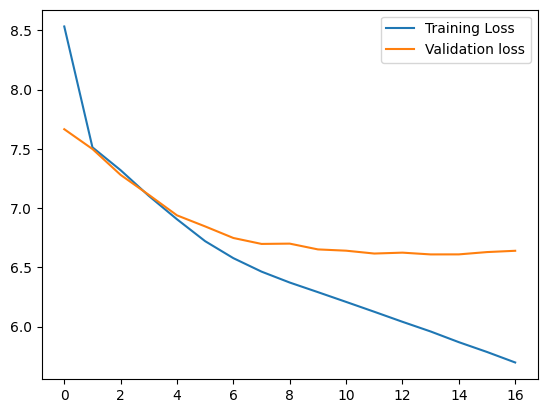

In [42]:
history = model.get_history()
val_loss = history.history['val_loss']
loss = history.history['loss']
epochs = [epoch for epoch in range(len(val_loss))]
plt.plot(epochs, loss, label = "Training Loss")
plt.plot(epochs, val_loss, label = "Validation loss")
plt.legend()
plt.show()

In [43]:
model = LSTM4Rec(x_train_sequence,y_train,**parameters)
preds = model.test_model(x_test_sequence,y_test,path='../models/lstm/lstm_checkpoint',stored=True)


res = []
for i in tqdm(range(len(preds))):
  t = np.argsort(preds[i])[::-1][:100]
  if y_test[i] in t:
    res.append(1/(np.where(t == y_test[i])[0]+1))
  else:
    res.append(0)

print(np.mean(res))

Checkpoint dir is recsys2022_project/models/lstm/lstm_checkpoint
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          1516224   
                                                                 
 lstm_3 (LSTM)               (None, 512)               1181696   
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 23691)             6088587   
                                                                 
Total params: 8,917,835
Trainable params: 7,401,611
Non-trainable params: 1,516,224
_____________________________________

2022-12-06 05:14:49.910847: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7734448152 exceeds 10% of free system memory.
100%|██████████| 81618/81618 [02:42<00:00, 500.85it/s]


[0.1481399]


/home/jupyter/env/lib/python3.7/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
